In [12]:
import pickle
import numpy
import pandas
import itertools

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from collections import Counter

%matplotlib inline
from matplotlib import pyplot, rcParams
from jupyter_progressbar import ProgressBar

# rcParams['font.family'] = 'Lucinda Console'
rcParams['font.size'] = '24'
rcParams['figure.figsize'] = (20, 10)
rcParams['figure.dpi'] = 100

In [2]:
# Hopefully stable way to load data cross-pandas versions
with open('data.p3', 'rb') as f:
        columns, matrix = pickle.load(f)

data = pandas.DataFrame(matrix, columns=columns)

In [3]:
# How the data was stored initially
#
# with open('data.p3', 'wb') as f:
#     pickle.dump(
#         (data.columns, data.as_matrix()), f
#     )

In [4]:
labels = ['GALAXY', 'QSO', 'STAR']
class_to_label = {l: i for i, l in enumerate(labels)}

class_labels = numpy.array([class_to_label[c] for c in data['class']])

# Input columns, they should not include the actual class of course.
columns = list(set(data.columns) - {'class'})

In [5]:
# Zero mean, standard deviation 1. It's OK to normalize on the test data as well, I guess,
# since there are many samples.
for column in columns:
    data[column] = data[column] - data[column].mean()
    data[column] = data[column] / data[column].std()

In [6]:
def extract_balanced_indices(y, f=0.2):
    """Based on labels in y, returns at iterator that each time
    stochastically extracts f fraction of each class w.r.t. the
    lowest class count. Returns a boolean 1D array."""
    counts = Counter(y)
    n = round(f * min(counts.values()))
    
    counts = Counter(y)
    enum = min(counts.values())

    denom = numpy.array([counts[i] for i in y])
    frac = f * enum / denom
    
    def it():
        nonlocal frac, y
        while True:
            yield numpy.random.rand(len(y)) < frac
    return it()

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Showing normalized confusion matrix")
    else:
        print('Showing confusion matrix, without normalization')
    #print(cm)
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
#     pyplot.title(title)
#     pyplot.colorbar()
    tick_marks = numpy.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.tight_layout()

In [8]:
test_indices = next(extract_balanced_indices(data['class'], f=0.2))
train, test = data[~test_indices], data[test_indices]

X_train, X_test = train[columns].as_matrix(), test[columns].as_matrix()
y_train = numpy.array(list(map(class_to_label.get, train['class'])))
y_test = numpy.array(list(map(class_to_label.get, test['class'])))

In [10]:
# Create a 6-layer Neural network, 14 input features are densly connected to first a
# 32 node relu-layer, then 48 node, 32, 16, and 8 node relu layer, finally the output
# i a 3 node softmax-layer to predict for the three classes.

input = last = Input(shape = X_train.shape[1:])
for i in [32, 48, 32, 16, 8]:
    last = Dense(i, activation='relu')(last)
#     last = BatchNormalization()(last)
last = Dense(3, activation='softmax')(last)
# last = BatchNormalization()(last)

model = Model(inputs=[input], output=last)

# A new network, so tany previous learning curves can be deleted
if 'history' in globals():
    del history

/home/herbert/.virtualenvs/astron/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':


In [13]:
balancer = extract_balanced_indices(y_train, f=1.0)

optimizer = Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

for _, idx in zip(ProgressBar(range(1000)), balancer):
    idx = next(balancer)
    perm = numpy.random.permutation(idx.sum())
    h = model.fit(
        X_train[idx][perm], y_train[idx][perm],
        validation_data=(X_test, y_test),
        epochs=1, batch_size=4 * 2048, verbose=1
    )
    if 'history' in globals():
        for k in history.history:
            history.history[k].extend(h.history[k])
    else:
        history = h

Train on 779429 samples, validate on 193733 samples
Epoch 1/1
779429/779429 [==============================] - 4s 5us/step - loss: 0.8824 - acc: 0.6199 - val_loss: 0.6191 - val_acc: 0.7847
Train on 779202 samples, validate on 193733 samples
Epoch 1/1
779202/779202 [==============================] - 2s 2us/step - loss: 0.4385 - acc: 0.8447 - val_loss: 0.3178 - val_acc: 0.9007
Train on 778758 samples, validate on 193733 samples
Epoch 1/1
778758/778758 [==============================] - 2s 2us/step - loss: 0.2837 - acc: 0.9132 - val_loss: 0.2610 - val_acc: 0.9183
Train on 779197 samples, validate on 193733 samples
Epoch 1/1
779197/779197 [==============================] - 2s 2us/step - loss: 0.2521 - acc: 0.9212 - val_loss: 0.2453 - val_acc: 0.9219
Train on 779263 samples, validate on 193733 samples
Epoch 1/1
779263/779263 [==============================] - 2s 2us/step - loss: 0.2359 - acc: 0.9261 - val_loss: 0.2268 - val_acc: 0.9292
Train on 778792 samples, validate on 193733 samples
Epo

779215/779215 [==============================] - 2s 3us/step - loss: 0.1548 - acc: 0.9511 - val_loss: 0.1515 - val_acc: 0.9522
Train on 778788 samples, validate on 193733 samples
Epoch 1/1
778788/778788 [==============================] - 2s 2us/step - loss: 0.1552 - acc: 0.9511 - val_loss: 0.1520 - val_acc: 0.9519
Train on 778970 samples, validate on 193733 samples
Epoch 1/1
778970/778970 [==============================] - 2s 2us/step - loss: 0.1545 - acc: 0.9513 - val_loss: 0.1525 - val_acc: 0.9517
Train on 779244 samples, validate on 193733 samples
Epoch 1/1
779244/779244 [==============================] - 2s 3us/step - loss: 0.1542 - acc: 0.9513 - val_loss: 0.1506 - val_acc: 0.9524
Train on 779329 samples, validate on 193733 samples
Epoch 1/1
779329/779329 [==============================] - 2s 2us/step - loss: 0.1540 - acc: 0.9513 - val_loss: 0.1499 - val_acc: 0.9527
Train on 777952 samples, validate on 193733 samples
Epoch 1/1
777952/777952 [==============================] - 2s 2us

778205/778205 [==============================] - 3s 4us/step - loss: 0.1438 - acc: 0.9540 - val_loss: 0.1421 - val_acc: 0.9540
Train on 779062 samples, validate on 193733 samples
Epoch 1/1
779062/779062 [==============================] - 4s 5us/step - loss: 0.1427 - acc: 0.9543 - val_loss: 0.1417 - val_acc: 0.9547
Train on 779803 samples, validate on 193733 samples
Epoch 1/1
779803/779803 [==============================] - 3s 4us/step - loss: 0.1430 - acc: 0.9544 - val_loss: 0.1409 - val_acc: 0.9548
Train on 779286 samples, validate on 193733 samples
Epoch 1/1
779286/779286 [==============================] - 4s 5us/step - loss: 0.1440 - acc: 0.9542 - val_loss: 0.1407 - val_acc: 0.9550
Train on 778980 samples, validate on 193733 samples
Epoch 1/1
778980/778980 [==============================] - 3s 4us/step - loss: 0.1435 - acc: 0.9541 - val_loss: 0.1437 - val_acc: 0.9539
Train on 778704 samples, validate on 193733 samples
Epoch 1/1
778704/778704 [==============================] - 3s 4us

779290/779290 [==============================] - 3s 4us/step - loss: 0.1391 - acc: 0.9554 - val_loss: 0.1369 - val_acc: 0.9562
Train on 778997 samples, validate on 193733 samples
Epoch 1/1
778997/778997 [==============================] - 3s 4us/step - loss: 0.1388 - acc: 0.9554 - val_loss: 0.1369 - val_acc: 0.9558
Train on 778586 samples, validate on 193733 samples
Epoch 1/1
778586/778586 [==============================] - 3s 4us/step - loss: 0.1381 - acc: 0.9557 - val_loss: 0.1373 - val_acc: 0.9559
Train on 779184 samples, validate on 193733 samples
Epoch 1/1
779184/779184 [==============================] - 3s 4us/step - loss: 0.1385 - acc: 0.9558 - val_loss: 0.1359 - val_acc: 0.9563
Train on 779136 samples, validate on 193733 samples
Epoch 1/1
779136/779136 [==============================] - 3s 4us/step - loss: 0.1379 - acc: 0.9557 - val_loss: 0.1356 - val_acc: 0.9565
Train on 778317 samples, validate on 193733 samples
Epoch 1/1
778317/778317 [==============================] - 3s 4us

778648/778648 [==============================] - 4s 5us/step - loss: 0.1350 - acc: 0.9567 - val_loss: 0.1337 - val_acc: 0.9568
Train on 779681 samples, validate on 193733 samples
Epoch 1/1
779681/779681 [==============================] - 3s 4us/step - loss: 0.1343 - acc: 0.9570 - val_loss: 0.1329 - val_acc: 0.9574
Train on 779754 samples, validate on 193733 samples
Epoch 1/1
779754/779754 [==============================] - 3s 4us/step - loss: 0.1340 - acc: 0.9571 - val_loss: 0.1343 - val_acc: 0.9568
Train on 779036 samples, validate on 193733 samples
Epoch 1/1
779036/779036 [==============================] - 3s 4us/step - loss: 0.1349 - acc: 0.9566 - val_loss: 0.1335 - val_acc: 0.9572
Train on 778799 samples, validate on 193733 samples
Epoch 1/1
778799/778799 [==============================] - 3s 4us/step - loss: 0.1347 - acc: 0.9568 - val_loss: 0.1338 - val_acc: 0.9570
Train on 778771 samples, validate on 193733 samples
Epoch 1/1
778771/778771 [==============================] - 3s 4us

779475/779475 [==============================] - 3s 4us/step - loss: 0.1328 - acc: 0.9573 - val_loss: 0.1314 - val_acc: 0.9576
Train on 779085 samples, validate on 193733 samples
Epoch 1/1
779085/779085 [==============================] - 4s 5us/step - loss: 0.1315 - acc: 0.9576 - val_loss: 0.1313 - val_acc: 0.9580
Train on 779370 samples, validate on 193733 samples
Epoch 1/1
779370/779370 [==============================] - 3s 4us/step - loss: 0.1326 - acc: 0.9575 - val_loss: 0.1305 - val_acc: 0.9583
Train on 778674 samples, validate on 193733 samples
Epoch 1/1
778674/778674 [==============================] - 3s 4us/step - loss: 0.1321 - acc: 0.9575 - val_loss: 0.1342 - val_acc: 0.9564
Train on 779759 samples, validate on 193733 samples
Epoch 1/1
779759/779759 [==============================] - 3s 4us/step - loss: 0.1322 - acc: 0.9573 - val_loss: 0.1303 - val_acc: 0.9580
Train on 779373 samples, validate on 193733 samples
Epoch 1/1
779373/779373 [==============================] - 3s 4us

778854/778854 [==============================] - 3s 4us/step - loss: 0.1322 - acc: 0.9574 - val_loss: 0.1297 - val_acc: 0.9582
Train on 779982 samples, validate on 193733 samples
Epoch 1/1
779982/779982 [==============================] - 3s 4us/step - loss: 0.1304 - acc: 0.9581 - val_loss: 0.1297 - val_acc: 0.9582
Train on 778534 samples, validate on 193733 samples
Epoch 1/1
778534/778534 [==============================] - 3s 4us/step - loss: 0.1304 - acc: 0.9578 - val_loss: 0.1296 - val_acc: 0.9579
Train on 779710 samples, validate on 193733 samples
Epoch 1/1
779710/779710 [==============================] - 3s 4us/step - loss: 0.1299 - acc: 0.9580 - val_loss: 0.1286 - val_acc: 0.9586
Train on 779093 samples, validate on 193733 samples
Epoch 1/1
779093/779093 [==============================] - 3s 4us/step - loss: 0.1296 - acc: 0.9581 - val_loss: 0.1291 - val_acc: 0.9585
Train on 778791 samples, validate on 193733 samples
Epoch 1/1
778791/778791 [==============================] - 3s 4us

778524/778524 [==============================] - 4s 5us/step - loss: 0.1286 - acc: 0.9585 - val_loss: 0.1272 - val_acc: 0.9589
Train on 778768 samples, validate on 193733 samples
Epoch 1/1
778768/778768 [==============================] - 4s 5us/step - loss: 0.1295 - acc: 0.9582 - val_loss: 0.1282 - val_acc: 0.9586
Train on 779376 samples, validate on 193733 samples
Epoch 1/1
779376/779376 [==============================] - 3s 4us/step - loss: 0.1289 - acc: 0.9583 - val_loss: 0.1282 - val_acc: 0.9590
Train on 778306 samples, validate on 193733 samples
Epoch 1/1
778306/778306 [==============================] - 4s 5us/step - loss: 0.1290 - acc: 0.9585 - val_loss: 0.1272 - val_acc: 0.9589
Train on 778622 samples, validate on 193733 samples
Epoch 1/1
778622/778622 [==============================] - 4s 5us/step - loss: 0.1286 - acc: 0.9586 - val_loss: 0.1280 - val_acc: 0.9589
Train on 779562 samples, validate on 193733 samples
Epoch 1/1
779562/779562 [==============================] - 3s 4us

779107/779107 [==============================] - 3s 4us/step - loss: 0.1277 - acc: 0.9590 - val_loss: 0.1258 - val_acc: 0.9596
Train on 778820 samples, validate on 193733 samples
Epoch 1/1
778820/778820 [==============================] - 3s 4us/step - loss: 0.1273 - acc: 0.9589 - val_loss: 0.1263 - val_acc: 0.9596
Train on 779406 samples, validate on 193733 samples
Epoch 1/1
779406/779406 [==============================] - 3s 4us/step - loss: 0.1273 - acc: 0.9589 - val_loss: 0.1260 - val_acc: 0.9595
Train on 777608 samples, validate on 193733 samples
Epoch 1/1
777608/777608 [==============================] - 3s 4us/step - loss: 0.1270 - acc: 0.9590 - val_loss: 0.1261 - val_acc: 0.9592
Train on 778921 samples, validate on 193733 samples
Epoch 1/1
778921/778921 [==============================] - 3s 4us/step - loss: 0.1276 - acc: 0.9589 - val_loss: 0.1266 - val_acc: 0.9592
Train on 779288 samples, validate on 193733 samples
Epoch 1/1
779288/779288 [==============================] - 3s 4us

779501/779501 [==============================] - 3s 4us/step - loss: 0.1265 - acc: 0.9591 - val_loss: 0.1267 - val_acc: 0.9591
Train on 779603 samples, validate on 193733 samples
Epoch 1/1
779603/779603 [==============================] - 3s 4us/step - loss: 0.1270 - acc: 0.9590 - val_loss: 0.1272 - val_acc: 0.9590
Train on 778672 samples, validate on 193733 samples
Epoch 1/1
778672/778672 [==============================] - 3s 4us/step - loss: 0.1259 - acc: 0.9592 - val_loss: 0.1251 - val_acc: 0.9598
Train on 778923 samples, validate on 193733 samples
Epoch 1/1
778923/778923 [==============================] - 3s 4us/step - loss: 0.1264 - acc: 0.9593 - val_loss: 0.1275 - val_acc: 0.9590
Train on 779252 samples, validate on 193733 samples
Epoch 1/1
779252/779252 [==============================] - 3s 4us/step - loss: 0.1271 - acc: 0.9591 - val_loss: 0.1253 - val_acc: 0.9596
Train on 778890 samples, validate on 193733 samples
Epoch 1/1
778890/778890 [==============================] - 3s 4us

779712/779712 [==============================] - 3s 4us/step - loss: 0.1286 - acc: 0.9587 - val_loss: 0.1261 - val_acc: 0.9596
Train on 778342 samples, validate on 193733 samples
Epoch 1/1
778342/778342 [==============================] - 3s 4us/step - loss: 0.1259 - acc: 0.9592 - val_loss: 0.1277 - val_acc: 0.9589
Train on 779182 samples, validate on 193733 samples
Epoch 1/1
779182/779182 [==============================] - 3s 4us/step - loss: 0.1262 - acc: 0.9593 - val_loss: 0.1260 - val_acc: 0.9594
Train on 779088 samples, validate on 193733 samples
Epoch 1/1
779088/779088 [==============================] - 3s 4us/step - loss: 0.1257 - acc: 0.9594 - val_loss: 0.1245 - val_acc: 0.9600
Train on 779170 samples, validate on 193733 samples
Epoch 1/1
779170/779170 [==============================] - 3s 4us/step - loss: 0.1256 - acc: 0.9595 - val_loss: 0.1250 - val_acc: 0.9599
Train on 778748 samples, validate on 193733 samples
Epoch 1/1
778748/778748 [==============================] - 3s 4us

780229/780229 [==============================] - 3s 4us/step - loss: 0.1258 - acc: 0.9594 - val_loss: 0.1252 - val_acc: 0.9596
Train on 778361 samples, validate on 193733 samples
Epoch 1/1
778361/778361 [==============================] - 3s 4us/step - loss: 0.1244 - acc: 0.9597 - val_loss: 0.1241 - val_acc: 0.9601
Train on 779342 samples, validate on 193733 samples
Epoch 1/1
779342/779342 [==============================] - 3s 4us/step - loss: 0.1257 - acc: 0.9593 - val_loss: 0.1240 - val_acc: 0.9601
Train on 779340 samples, validate on 193733 samples
Epoch 1/1
779340/779340 [==============================] - 3s 4us/step - loss: 0.1248 - acc: 0.9600 - val_loss: 0.1241 - val_acc: 0.9599
Train on 778713 samples, validate on 193733 samples
Epoch 1/1
778713/778713 [==============================] - 3s 4us/step - loss: 0.1249 - acc: 0.9599 - val_loss: 0.1246 - val_acc: 0.9599
Train on 778681 samples, validate on 193733 samples
Epoch 1/1
778681/778681 [==============================] - 3s 4us

779282/779282 [==============================] - 3s 4us/step - loss: 0.1238 - acc: 0.9600 - val_loss: 0.1239 - val_acc: 0.9602
Train on 778818 samples, validate on 193733 samples
Epoch 1/1
778818/778818 [==============================] - 3s 4us/step - loss: 0.1247 - acc: 0.9598 - val_loss: 0.1253 - val_acc: 0.9597
Train on 779524 samples, validate on 193733 samples
Epoch 1/1
779524/779524 [==============================] - 3s 4us/step - loss: 0.1242 - acc: 0.9599 - val_loss: 0.1237 - val_acc: 0.9599
Train on 779937 samples, validate on 193733 samples
Epoch 1/1
779937/779937 [==============================] - 3s 4us/step - loss: 0.1244 - acc: 0.9599 - val_loss: 0.1239 - val_acc: 0.9601
Train on 778703 samples, validate on 193733 samples
Epoch 1/1
778703/778703 [==============================] - 3s 4us/step - loss: 0.1247 - acc: 0.9598 - val_loss: 0.1246 - val_acc: 0.9598
Train on 779453 samples, validate on 193733 samples
Epoch 1/1
779453/779453 [==============================] - 3s 4us

779071/779071 [==============================] - 3s 4us/step - loss: 0.1242 - acc: 0.9600 - val_loss: 0.1238 - val_acc: 0.9602
Train on 778910 samples, validate on 193733 samples
Epoch 1/1
778910/778910 [==============================] - 3s 4us/step - loss: 0.1239 - acc: 0.9601 - val_loss: 0.1234 - val_acc: 0.9602
Train on 778737 samples, validate on 193733 samples
Epoch 1/1
778737/778737 [==============================] - 4s 5us/step - loss: 0.1239 - acc: 0.9601 - val_loss: 0.1229 - val_acc: 0.9603
Train on 778840 samples, validate on 193733 samples
Epoch 1/1
778840/778840 [==============================] - 3s 4us/step - loss: 0.1238 - acc: 0.9602 - val_loss: 0.1250 - val_acc: 0.9599
Train on 779065 samples, validate on 193733 samples
Epoch 1/1
779065/779065 [==============================] - 3s 4us/step - loss: 0.1236 - acc: 0.9601 - val_loss: 0.1228 - val_acc: 0.9604
Train on 779116 samples, validate on 193733 samples
Epoch 1/1
779116/779116 [==============================] - 3s 4us

779251/779251 [==============================] - 3s 4us/step - loss: 0.1241 - acc: 0.9601 - val_loss: 0.1230 - val_acc: 0.9603
Train on 779179 samples, validate on 193733 samples
Epoch 1/1
779179/779179 [==============================] - 3s 4us/step - loss: 0.1232 - acc: 0.9605 - val_loss: 0.1235 - val_acc: 0.9601
Train on 778029 samples, validate on 193733 samples
Epoch 1/1
778029/778029 [==============================] - 3s 4us/step - loss: 0.1236 - acc: 0.9602 - val_loss: 0.1226 - val_acc: 0.9604
Train on 778437 samples, validate on 193733 samples
Epoch 1/1
778437/778437 [==============================] - 3s 4us/step - loss: 0.1234 - acc: 0.9601 - val_loss: 0.1249 - val_acc: 0.9597
Train on 778648 samples, validate on 193733 samples
Epoch 1/1
778648/778648 [==============================] - 3s 4us/step - loss: 0.1245 - acc: 0.9599 - val_loss: 0.1229 - val_acc: 0.9604
Train on 778623 samples, validate on 193733 samples
Epoch 1/1
778623/778623 [==============================] - 3s 4us

779528/779528 [==============================] - 3s 4us/step - loss: 0.1236 - acc: 0.9603 - val_loss: 0.1235 - val_acc: 0.9604
Train on 778448 samples, validate on 193733 samples
Epoch 1/1
778448/778448 [==============================] - 3s 4us/step - loss: 0.1233 - acc: 0.9603 - val_loss: 0.1235 - val_acc: 0.9602
Train on 778688 samples, validate on 193733 samples
Epoch 1/1
778688/778688 [==============================] - 3s 4us/step - loss: 0.1233 - acc: 0.9603 - val_loss: 0.1232 - val_acc: 0.9603
Train on 778055 samples, validate on 193733 samples
Epoch 1/1
778055/778055 [==============================] - 3s 4us/step - loss: 0.1228 - acc: 0.9606 - val_loss: 0.1230 - val_acc: 0.9604
Train on 778492 samples, validate on 193733 samples
Epoch 1/1
778492/778492 [==============================] - 3s 4us/step - loss: 0.1237 - acc: 0.9602 - val_loss: 0.1239 - val_acc: 0.9600
Train on 779187 samples, validate on 193733 samples
Epoch 1/1
779187/779187 [==============================] - 3s 4us

778427/778427 [==============================] - 3s 4us/step - loss: 0.1230 - acc: 0.9604 - val_loss: 0.1232 - val_acc: 0.9603
Train on 780769 samples, validate on 193733 samples
Epoch 1/1
780769/780769 [==============================] - 3s 4us/step - loss: 0.1230 - acc: 0.9604 - val_loss: 0.1218 - val_acc: 0.9607
Train on 779005 samples, validate on 193733 samples
Epoch 1/1
779005/779005 [==============================] - 3s 4us/step - loss: 0.1226 - acc: 0.9606 - val_loss: 0.1229 - val_acc: 0.9605
Train on 779618 samples, validate on 193733 samples
Epoch 1/1
779618/779618 [==============================] - 3s 4us/step - loss: 0.1227 - acc: 0.9606 - val_loss: 0.1228 - val_acc: 0.9605
Train on 779024 samples, validate on 193733 samples
Epoch 1/1
779024/779024 [==============================] - 3s 4us/step - loss: 0.1229 - acc: 0.9605 - val_loss: 0.1220 - val_acc: 0.9609
Train on 779193 samples, validate on 193733 samples
Epoch 1/1
779193/779193 [==============================] - 3s 4us

778884/778884 [==============================] - 2s 2us/step - loss: 0.1225 - acc: 0.9606 - val_loss: 0.1221 - val_acc: 0.9609
Train on 778352 samples, validate on 193733 samples
Epoch 1/1
778352/778352 [==============================] - 2s 2us/step - loss: 0.1227 - acc: 0.9606 - val_loss: 0.1266 - val_acc: 0.9592
Train on 778640 samples, validate on 193733 samples
Epoch 1/1
778640/778640 [==============================] - 2s 2us/step - loss: 0.1231 - acc: 0.9602 - val_loss: 0.1232 - val_acc: 0.9606
Train on 779115 samples, validate on 193733 samples
Epoch 1/1
779115/779115 [==============================] - 2s 2us/step - loss: 0.1225 - acc: 0.9606 - val_loss: 0.1224 - val_acc: 0.9605
Train on 777641 samples, validate on 193733 samples
Epoch 1/1
777641/777641 [==============================] - 2s 2us/step - loss: 0.1223 - acc: 0.9608 - val_loss: 0.1218 - val_acc: 0.9609
Train on 779000 samples, validate on 193733 samples
Epoch 1/1
779000/779000 [==============================] - 2s 2us

779290/779290 [==============================] - 2s 2us/step - loss: 0.1217 - acc: 0.9608 - val_loss: 0.1233 - val_acc: 0.9603
Train on 778829 samples, validate on 193733 samples
Epoch 1/1
778829/778829 [==============================] - 2s 2us/step - loss: 0.1230 - acc: 0.9605 - val_loss: 0.1217 - val_acc: 0.9610
Train on 778433 samples, validate on 193733 samples
Epoch 1/1
778433/778433 [==============================] - 2s 2us/step - loss: 0.1221 - acc: 0.9605 - val_loss: 0.1238 - val_acc: 0.9602
Train on 778467 samples, validate on 193733 samples
Epoch 1/1
778467/778467 [==============================] - 2s 2us/step - loss: 0.1229 - acc: 0.9604 - val_loss: 0.1241 - val_acc: 0.9601
Train on 779067 samples, validate on 193733 samples
Epoch 1/1
779067/779067 [==============================] - 2s 2us/step - loss: 0.1236 - acc: 0.9603 - val_loss: 0.1219 - val_acc: 0.9610
Train on 779498 samples, validate on 193733 samples
Epoch 1/1
779498/779498 [==============================] - 2s 2us

777060/777060 [==============================] - 2s 2us/step - loss: 0.1218 - acc: 0.9606 - val_loss: 0.1223 - val_acc: 0.9607
Train on 779651 samples, validate on 193733 samples
Epoch 1/1
779651/779651 [==============================] - 2s 2us/step - loss: 0.1216 - acc: 0.9608 - val_loss: 0.1224 - val_acc: 0.9608
Train on 778354 samples, validate on 193733 samples
Epoch 1/1
778354/778354 [==============================] - 2s 2us/step - loss: 0.1224 - acc: 0.9605 - val_loss: 0.1215 - val_acc: 0.9612
Train on 779018 samples, validate on 193733 samples
Epoch 1/1
779018/779018 [==============================] - 2s 2us/step - loss: 0.1214 - acc: 0.9611 - val_loss: 0.1219 - val_acc: 0.9607
Train on 777403 samples, validate on 193733 samples
Epoch 1/1
777403/777403 [==============================] - 2s 2us/step - loss: 0.1217 - acc: 0.9607 - val_loss: 0.1218 - val_acc: 0.9610
Train on 779645 samples, validate on 193733 samples
Epoch 1/1
779645/779645 [==============================] - 2s 2us

780019/780019 [==============================] - 2s 2us/step - loss: 0.1216 - acc: 0.9608 - val_loss: 0.1219 - val_acc: 0.9609
Train on 778829 samples, validate on 193733 samples
Epoch 1/1
778829/778829 [==============================] - 2s 2us/step - loss: 0.1213 - acc: 0.9608 - val_loss: 0.1214 - val_acc: 0.9613
Train on 778763 samples, validate on 193733 samples
Epoch 1/1
778763/778763 [==============================] - 2s 2us/step - loss: 0.1217 - acc: 0.9610 - val_loss: 0.1222 - val_acc: 0.9608
Train on 779370 samples, validate on 193733 samples
Epoch 1/1
779370/779370 [==============================] - 2s 2us/step - loss: 0.1218 - acc: 0.9609 - val_loss: 0.1222 - val_acc: 0.9607
Train on 778808 samples, validate on 193733 samples
Epoch 1/1
778808/778808 [==============================] - 2s 2us/step - loss: 0.1211 - acc: 0.9612 - val_loss: 0.1218 - val_acc: 0.9608
Train on 779324 samples, validate on 193733 samples
Epoch 1/1
779324/779324 [==============================] - 2s 2us

778852/778852 [==============================] - 2s 2us/step - loss: 0.1253 - acc: 0.9597 - val_loss: 0.1222 - val_acc: 0.9609
Train on 778954 samples, validate on 193733 samples
Epoch 1/1
778954/778954 [==============================] - 2s 2us/step - loss: 0.1220 - acc: 0.9605 - val_loss: 0.1225 - val_acc: 0.9610
Train on 778361 samples, validate on 193733 samples
Epoch 1/1
778361/778361 [==============================] - 2s 2us/step - loss: 0.1212 - acc: 0.9611 - val_loss: 0.1230 - val_acc: 0.9606
Train on 779444 samples, validate on 193733 samples
Epoch 1/1
779444/779444 [==============================] - 2s 2us/step - loss: 0.1223 - acc: 0.9606 - val_loss: 0.1227 - val_acc: 0.9608
Train on 779768 samples, validate on 193733 samples
Epoch 1/1
779768/779768 [==============================] - 2s 2us/step - loss: 0.1218 - acc: 0.9606 - val_loss: 0.1220 - val_acc: 0.9609
Train on 778502 samples, validate on 193733 samples
Epoch 1/1
778502/778502 [==============================] - 2s 2us

778562/778562 [==============================] - 2s 2us/step - loss: 0.1211 - acc: 0.9610 - val_loss: 0.1213 - val_acc: 0.9612
Train on 777985 samples, validate on 193733 samples
Epoch 1/1
777985/777985 [==============================] - 2s 2us/step - loss: 0.1215 - acc: 0.9608 - val_loss: 0.1213 - val_acc: 0.9613
Train on 778719 samples, validate on 193733 samples
Epoch 1/1
778719/778719 [==============================] - 2s 2us/step - loss: 0.1208 - acc: 0.9611 - val_loss: 0.1216 - val_acc: 0.9611
Train on 779332 samples, validate on 193733 samples
Epoch 1/1
779332/779332 [==============================] - 2s 2us/step - loss: 0.1211 - acc: 0.9611 - val_loss: 0.1221 - val_acc: 0.9608
Train on 779148 samples, validate on 193733 samples
Epoch 1/1
779148/779148 [==============================] - 2s 2us/step - loss: 0.1213 - acc: 0.9609 - val_loss: 0.1236 - val_acc: 0.9604
Train on 778995 samples, validate on 193733 samples
Epoch 1/1
778995/778995 [==============================] - 2s 2us

778216/778216 [==============================] - 2s 2us/step - loss: 0.1213 - acc: 0.9610 - val_loss: 0.1213 - val_acc: 0.9612
Train on 778815 samples, validate on 193733 samples
Epoch 1/1
778815/778815 [==============================] - 2s 2us/step - loss: 0.1211 - acc: 0.9610 - val_loss: 0.1210 - val_acc: 0.9613
Train on 779890 samples, validate on 193733 samples
Epoch 1/1
779890/779890 [==============================] - 2s 2us/step - loss: 0.1209 - acc: 0.9611 - val_loss: 0.1214 - val_acc: 0.9611
Train on 779141 samples, validate on 193733 samples
Epoch 1/1
779141/779141 [==============================] - 2s 2us/step - loss: 0.1212 - acc: 0.9610 - val_loss: 0.1214 - val_acc: 0.9608
Train on 779009 samples, validate on 193733 samples
Epoch 1/1
779009/779009 [==============================] - 2s 2us/step - loss: 0.1208 - acc: 0.9610 - val_loss: 0.1209 - val_acc: 0.9612
Train on 779063 samples, validate on 193733 samples
Epoch 1/1
779063/779063 [==============================] - 2s 2us

(0, 500)

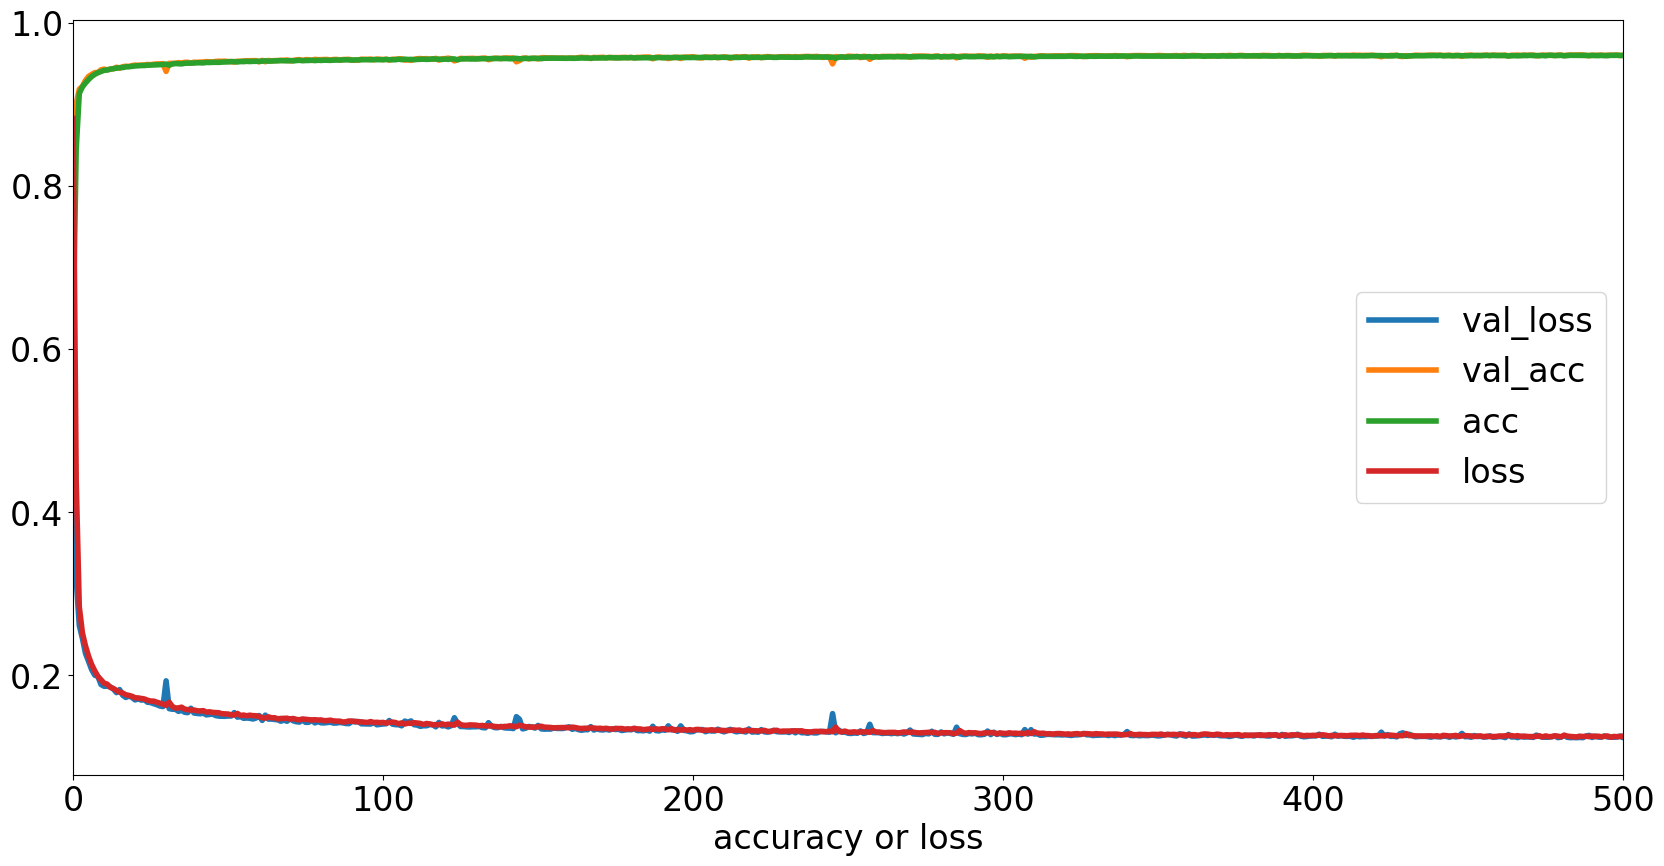

In [14]:
for k, v in history.history.items():
    pyplot.plot(v, label=k, linewidth=4)
    
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.xlabel('accuracy or loss')
pyplot.xlim(0, 500)

In [15]:
y_pred = model.predict(X_test, verbose=1, batch_size=4 * 2048)

print(classification_report(y_test, y_pred.argmax(1), target_names=labels))

193733/193733 [==============================] - 0s 1us/step
             precision    recall  f1-score   support

     GALAXY       0.93      0.97      0.95     64665
        QSO       0.97      0.94      0.95     64264
       STAR       0.98      0.97      0.98     64804

avg / total       0.96      0.96      0.96    193733



Showing confusion matrix, without normalization


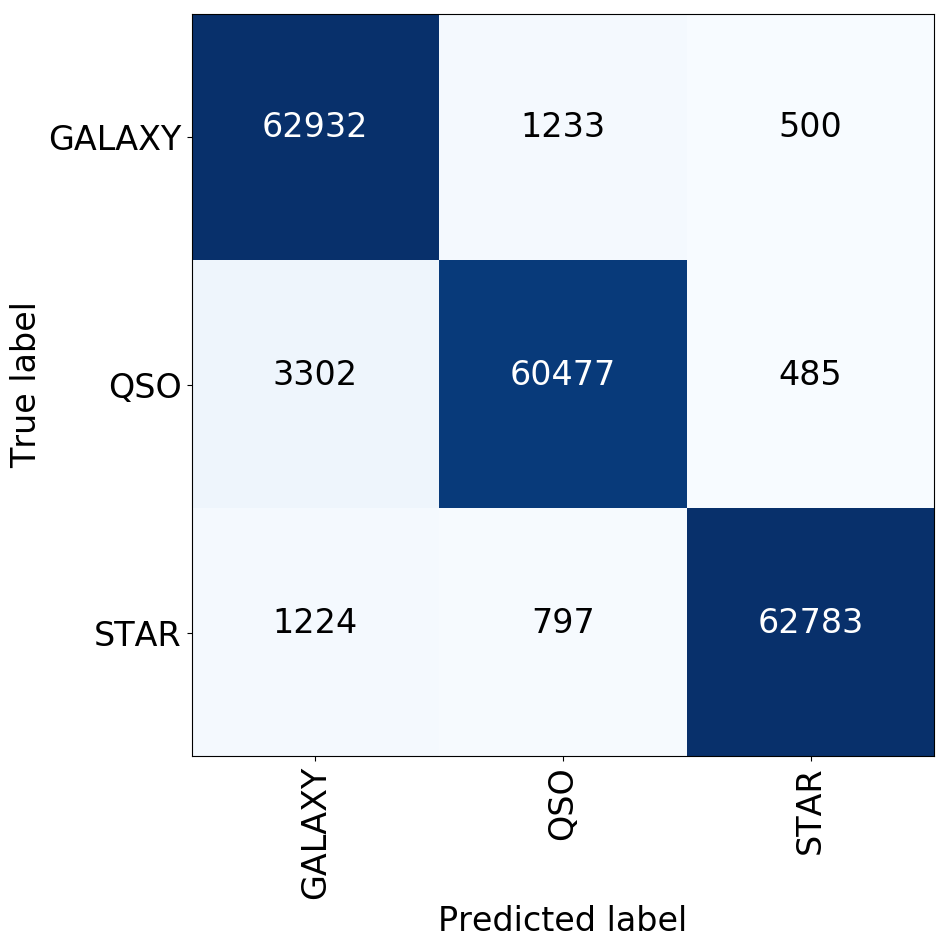

In [16]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred.argmax(1)), labels, title='')
pyplot.tight_layout()